In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from cvxopt import matrix, solvers
import warnings
warnings.filterwarnings("ignore")

# Download historical data

In [3]:
# Define tickers and date range
universe_tickers = ['FXE', 'EWJ', 'GLD', 'QQQ', 'SHV', 'DBA', 'USO', 'XBI', 'ILF', 'EPP', 'FEZ']
target_tickers = ['AAPL', 'SPY']
start_date = '2020-01-01'
end_date = '2021-03-30'

# Download historical data and calculate daily returns
universe_data = yf.download(universe_tickers, start=start_date, end=end_date)['Close'].dropna()
target_data = yf.download(target_tickers, start=start_date, end=end_date)['Close'].dropna()
universe_returns = universe_data.pct_change().dropna()
target_returns = target_data.pct_change().dropna()

[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  2 of 2 completed


# Two-fund Theorem with Target Beta

## 1. Compute Expected Returns and Covariance

In [4]:
historical_returns = universe_returns.loc['2020-01-02':'2021-01-02']
market_returns = target_returns['SPY'].loc['2020-01-02':'2021-01-02']  
expected_returns = historical_returns.mean()
# Compute covariance matrix and betas
cov_matrix = historical_returns.cov().values 
betas = historical_returns.corrwith(market_returns) 

## 2. Find $\alpha$

In [5]:
# Define target beta
beta_a = 0.5
beta_b = 1.5

# Set up cvxopt matrices
P = matrix(cov_matrix)
q = matrix(np.zeros(len(universe_tickers)))

# Constraints matrix
G = matrix(np.vstack([-np.eye(len(universe_tickers)), np.eye(len(universe_tickers))]))  # Non-negativity bounds
h = matrix(np.hstack([np.zeros(len(universe_tickers)), np.ones(len(universe_tickers))]))  # Weights between 0 and 1

# Equality constraints for weights sum to 1 and target beta
A = matrix(np.vstack([np.ones(len(universe_tickers)), betas.values]))
b_a = matrix([1.0, beta_a])  # Constraints for beta_a
b_b = matrix([1.0, beta_b])  # Constraints for beta_b

# Solve for optimal weights with beta_a
solvers.options['show_progress'] = False
solution_a = solvers.qp(P, q, G, h, A, b_a)
weights_a = np.array(solution_a['x']).flatten()

# Solve for optimal weights with beta_b
solution_b = solvers.qp(P, q, G, h, A, b_b)
weights_b = np.array(solution_b['x']).flatten()

# Display the optimal weights for both target betas
print("Optimal weights for beta_a:", weights_a)
print("Optimal weights for beta_b:", weights_b)

Optimal weights for beta_a: [5.20332665e-01 8.81638303e-06 3.02797470e-01 3.01821869e-06
 1.29206811e-01 3.37965929e-02 7.90888475e-07 1.38283345e-02
 1.42577250e-06 4.58603389e-06 1.94892123e-05]
Optimal weights for beta_b: [-0.13858346  1.10866343 -0.13858341 -0.13858349 -0.13858317 -0.13858317
 -0.1385832   1.1385835  -0.1385833  -0.13858344 -0.13858306]


In [6]:
beta_c = 3 # as an example

# Find alpha and apply Two fund-theorem to find the optimal weights
alpha = (beta_c-beta_b)/(beta_a-beta_b)
weights_c = alpha*weights_a+(1-alpha)*weights_b

# Display the optimal weights for beta_c
print("Optimal weights for beta_c:", weights_c)

Optimal weights for beta_c: [-1.12695765  2.77164536 -0.80065473 -0.34646326 -0.54026814 -0.39715281
 -0.34645919  2.82571625 -0.3464604  -0.34646548 -0.34648689]


# Hedging long position in AAPL

## a. Compute Beta_A & betas of the securities with respect to the S&P-500 index.

In [10]:
beta_A = np.corrcoef(target_returns["AAPL"], target_returns["SPY"])[0][1]
print("Beta of Apple with respect to S&P-500:", beta_A)
betas = universe_returns.corrwith(target_returns["SPY"]) 
print("Betas of the securities with respect to S&P-500:", betas)

Beta of Apple with respect to S&P-500: 0.8124177297842411
Betas of the securities with respect to S&P-500: Ticker
DBA    0.415617
EPP    0.902622
EWJ    0.815730
FEZ    0.889926
FXE    0.035548
GLD    0.156387
ILF    0.826449
QQQ    0.924858
SHV   -0.247818
USO    0.412891
XBI    0.728873
dtype: float64


## b. Beta hedge portfolio for AAPL

In [14]:
# Set up cvxopt matrices for the investment universe
P = matrix(universe_returns.cov().values)  # Covariance matrix for the universe
q = matrix(np.zeros(len(universe_tickers)))  # Linear term for variance minimization

# Constraints for non-negativity bounds
G = matrix(np.vstack([-np.eye(len(universe_tickers)), np.eye(len(universe_tickers))]))
h = matrix(np.hstack([np.zeros(len(universe_tickers)), np.ones(len(universe_tickers))]))

# Equality constraints for weights sum to 1 and target beta = beta_AAPL
A = matrix(np.vstack([np.ones(len(universe_tickers)), betas.values]))
b = matrix([1.0, beta_A])  # Target beta is the beta of AAPL

# Solve for optimal weights with target beta equal to beta_AAPL
solvers.options['show_progress'] = False
solution = solvers.qp(P, q, G, h, A, b)
weights_beta_hedging = np.array(solution['x']).flatten()

# Calculate expected return of the hedging portfolio
expected_returns = universe_returns.mean()
hedging_portfolio_return = np.dot(weights_beta_hedging, expected_returns)
hedging_portfolio_risk = np.dot(weights_beta_hedging.T, cov_matrix @ weights_beta_hedging)

print("Optimal weights for beta hedging portfolio (beta = AAPL):", weights_beta_hedging)
print("Expected daily return of the hedging portfolio:", hedging_portfolio_return)
print("Risk (variance) of the hedging portfolio:", hedging_portfolio_risk)

Optimal weights for beta hedging portfolio (beta = AAPL): [5.74562820e-02 1.05350087e-05 7.62186820e-01 9.61310374e-06
 9.34014635e-07 7.71558064e-07 2.09084422e-06 1.80326502e-01
 1.00602402e-06 1.94455682e-06 3.50054188e-06]
Expected daily return of the hedging portfolio: 0.0007272965395943154
Risk (variance) of the hedging portfolio: 0.0002470388751506625


1. How to use this portfolio to hedge the position in AAPL:

- To use this portfolio to hedge to position in AAPL. Since they all have the same beta, all we need to do is to short the amount of the portfolio which makes the amount $\beta_p * \text(portfolio\ value) = \beta_A * \text(AAPL\ value)$. Since $\beta_p = \beta_A$ we only need to short the same amount we hold in AAPL.


2. What is the expected return of the hedged portfolio:

- The expected return of the hedged portfolio will simply be the expected return of AAPl minus the expected return of the portfolio.

## c. Beta neutral portfolio

In [15]:
# Expand investment universe to include AAPL
investment_universe_extended = universe_tickers + ['AAPL']
universe_return_extended = pd.concat([universe_returns, target_returns['AAPL']], axis=1)

# Calculate covariance matrix and betas for the extended universe
cov_matrix_extended = universe_return_extended.cov().values
betas_extended = universe_return_extended.corrwith(market_returns)

# Set up cvxopt matrices for the extended investment universe
P_extended = matrix(cov_matrix_extended)
q_extended = matrix(np.zeros(len(investment_universe_extended)))

# Constraints for non-negativity bounds
G_extended = matrix(np.vstack([-np.eye(len(investment_universe_extended)), np.eye(len(investment_universe_extended))]))
h_extended = matrix(np.hstack([np.zeros(len(investment_universe_extended)), np.ones(len(investment_universe_extended))]))

# Equality constraints for weights sum to 1 and target beta = 0 (beta neutral)
A_extended = matrix(np.vstack([np.ones(len(investment_universe_extended)), betas_extended.values]))
b_beta_neutral = matrix([1.0, 0.0])  # Target beta is 0 for a beta-neutral portfolio

# Solve for optimal weights with target beta equal to 0
solution_neutral = solvers.qp(P_extended, q_extended, G_extended, h_extended, A_extended, b_beta_neutral)
weights_beta_neutral = np.array(solution_neutral['x']).flatten()

# Calculate expected return and risk (variance) of the beta-neutral portfolio
expected_returns_extended = universe_return_extended.mean()
beta_neutral_return = np.dot(weights_beta_neutral, expected_returns_extended)
beta_neutral_risk = np.dot(weights_beta_neutral.T, cov_matrix_extended @ weights_beta_neutral)

print("Optimal weights for beta-neutral portfolio:", weights_beta_neutral)
print("Expected daily return of the beta-neutral portfolio:", beta_neutral_return)
print("Risk (variance) of the beta-neutral portfolio:", beta_neutral_risk)

Optimal weights for beta-neutral portfolio: [1.49819291e-01 1.45826229e-04 6.47014799e-02 7.18116340e-05
 2.52054672e-01 9.35809890e-03 3.42303801e-05 4.22096385e-03
 5.18024445e-01 8.52193308e-04 3.72009470e-04 3.44977401e-04]
Expected daily return of the beta-neutral portfolio: 0.00010031408780667166
Risk (variance) of the beta-neutral portfolio: 6.1513131994523e-06


As we can see the expected return of the hedging portfolio is higher compared to the beta neutral portfolio, but the risk (variance) of the hedging portfolio is larger compared to the beta neutral portfolio

# Comparison of two hedging strategy

## Compute the realized daily return

In [16]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# Define date range for evaluation
start_date_eval = '2021-01-03'
end_date_eval = '2021-03-30'

# Download historical data for investment universe and AAPL
evaluation_data = yf.download(universe_tickers + target_tickers, start=start_date_eval, end=end_date_eval)['Close'].dropna()

# Calculate daily returns for the evaluation period
evaluation_returns = evaluation_data.pct_change().dropna()

# Calculate the realized daily returns of the beta-hedging and beta-neutral portfolios
beta_hedging_returns = evaluation_returns[universe_tickers] @ weights_beta_hedging
beta_neutral_returns = evaluation_returns[universe_tickers + ['AAPL']] @ weights_beta_neutral

# Create a DataFrame to store both strategies' returns
portfolio_returns = pd.DataFrame({
    'Beta_Hedging': beta_hedging_returns,
    'Beta_Neutral': beta_neutral_returns
})

print(portfolio_returns.head())


[*********************100%%**********************]  13 of 13 completed

            Beta_Hedging  Beta_Neutral
Date                                  
2021-01-05      0.001808      0.006401
2021-01-06     -0.008544      0.005172
2021-01-07      0.005354      0.005703
2021-01-08     -0.025865      0.001744
2021-01-11     -0.003635     -0.014247


## Compute the performance metric

In [166]:
# Calculate expected returns and volatility (standard deviation)
expected_returns = portfolio_returns.mean()
volatility = portfolio_returns.std()

# Calculate 95% Value-at-Risk (VaR)
VaR_95 = portfolio_returns.quantile(0.05)

# Calculate skewness and kurtosis
skewness = portfolio_returns.apply(lambda x: skew(x))
kurt = portfolio_returns.apply(lambda x: kurtosis(x))

# Calculate Beta of each strategy with respect to SPY
market_returns_eval = evaluation_returns['SPY']
beta_hedging_beta = portfolio_returns['Beta_Hedging'].cov(market_returns_eval) / market_returns_eval.var()
beta_neutral_beta = portfolio_returns['Beta_Neutral'].cov(market_returns_eval) / market_returns_eval.var()

# Display metrics
metrics = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility,
    '95% VaR': VaR_95,
    'Skewness': skewness,
    'Kurtosis': kurt,
    'Beta': [beta_hedging_beta, beta_neutral_beta]
}, index=['Beta_Hedging', 'Beta_Neutral'])

metrics

,Expected Return,Volatility,95% VaR,Skewness,Kurtosis,Beta
Beta_Hedging,-0.001911,0.010146,-0.017453,-0.019845,-0.047825,0.505731
Beta_Neutral,-0.000839,0.010143,-0.019385,-0.512606,-0.237382,0.640368


<Figure size 1200x600 with 0 Axes>

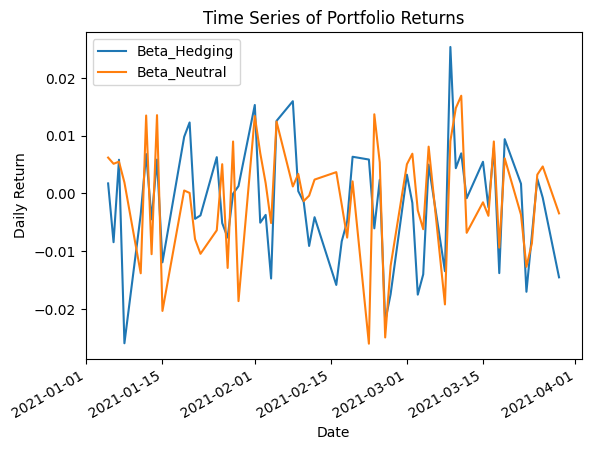

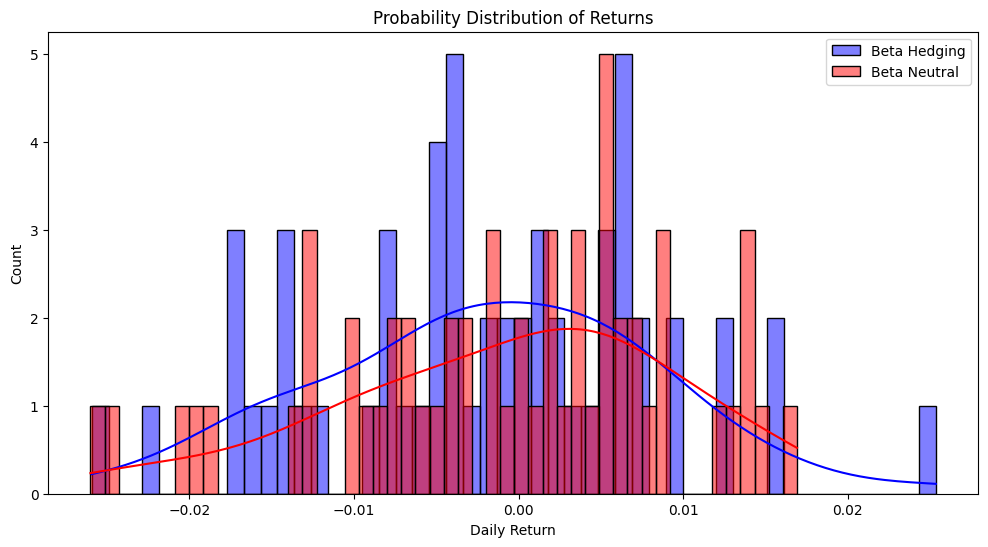

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot time series of returns
plt.figure(figsize=(12, 6))
portfolio_returns.plot(title="Time Series of Portfolio Returns")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.show()

# Plot probability distribution of returns
plt.figure(figsize=(12, 6))
sns.histplot(portfolio_returns['Beta_Hedging'], bins=50, kde=True, color='blue', label='Beta Hedging')
sns.histplot(portfolio_returns['Beta_Neutral'], bins=50, kde=True, color='red', label='Beta Neutral')
plt.title("Probability Distribution of Returns")
plt.xlabel("Daily Return")
plt.legend()
plt.show()